<h2 align="center">Лабораторна робота №5</h2>
<p style="margin-left: 500px">Роботу виконав студент з групи ФІ-21, Беркута Володимир</p>
<p style="margin-left: 50px"><i><b>Тема роботи:</b></i> "Методи інтерполювання зображень, цифровий зум".</br>
<i><b>Мета роботи:</b></i> опанувати сучасні методи інтерполювання зображень, навчитись визначити переваги і недоліки кожного з методів інтерполювання у ході застосування даних методів конкретно для зображень.</p>

<h2 align="center">Завдання до лабораторної роботи</h2>
<ol>
    <li>Ознайомитись з теоретичними відомостями до лабораторної роботи щодо виконання інтерполювання зображень з метою здійснення збільшення зображень і графічних елементів.</li>
    <li>Вивчити з математичної точки зору усі відомі методи інтерполювання, що наведені у даній лабораторній роботі.</li>
    <li>Після вивчення математичних методів програмно реалізувати інтерполювання функції (обрати самостійно) виду z=f(x, y) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур'є, інтерполювання з викорситанням методу найменших квадратів. Продемонструвати отримані результати.</li>
    <li>За основу розробки власних програмних реалізацій за бажанням можна брати наведені програмні коди.</li>
    <li>Програмно реалізувати інтерполювання зображення (взяти маленьке зображення і порівняно велике зображення) різними методами, а саме: лінійне інтерполювання, поліноміальне інтерполювання, інтерполювання з використанням розкладу в ряд Фур'є, інтерполювання з викорситанням методу найменших квадратів. Продемонструвати отримані результати. Визначити переваги і недоліки кожного з реалізованих методів.</li>
    <li>Сформувати звіт з лабораторної роботи у форматі PDF з отриманими результатами, надіслати його до класруму.</li>
    <li>Показати практичні результати викладачі і захистити роботу.</li>

<h2 align="center">Виконання лабораторної роботи</h2>

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

%matplotlib inline

cubes = cv.imread("original_img/img_for_interpolation.jpg")
cubes = cv.cvtColor(cubes, cv.COLOR_BGR2RGB)

monkey = cv.imread("original_img/monkey.jpg")
monkey = cv.cvtColor(monkey, cv.COLOR_BGR2RGB)
monkey_shape = monkey.shape
monkey = cv.resize(monkey, (int(monkey.shape[1]/4), int(monkey.shape[0]/4)))

print("Setup complete")

Setup complete


<h3 align="center">Білінійна інтерполяція</h3>

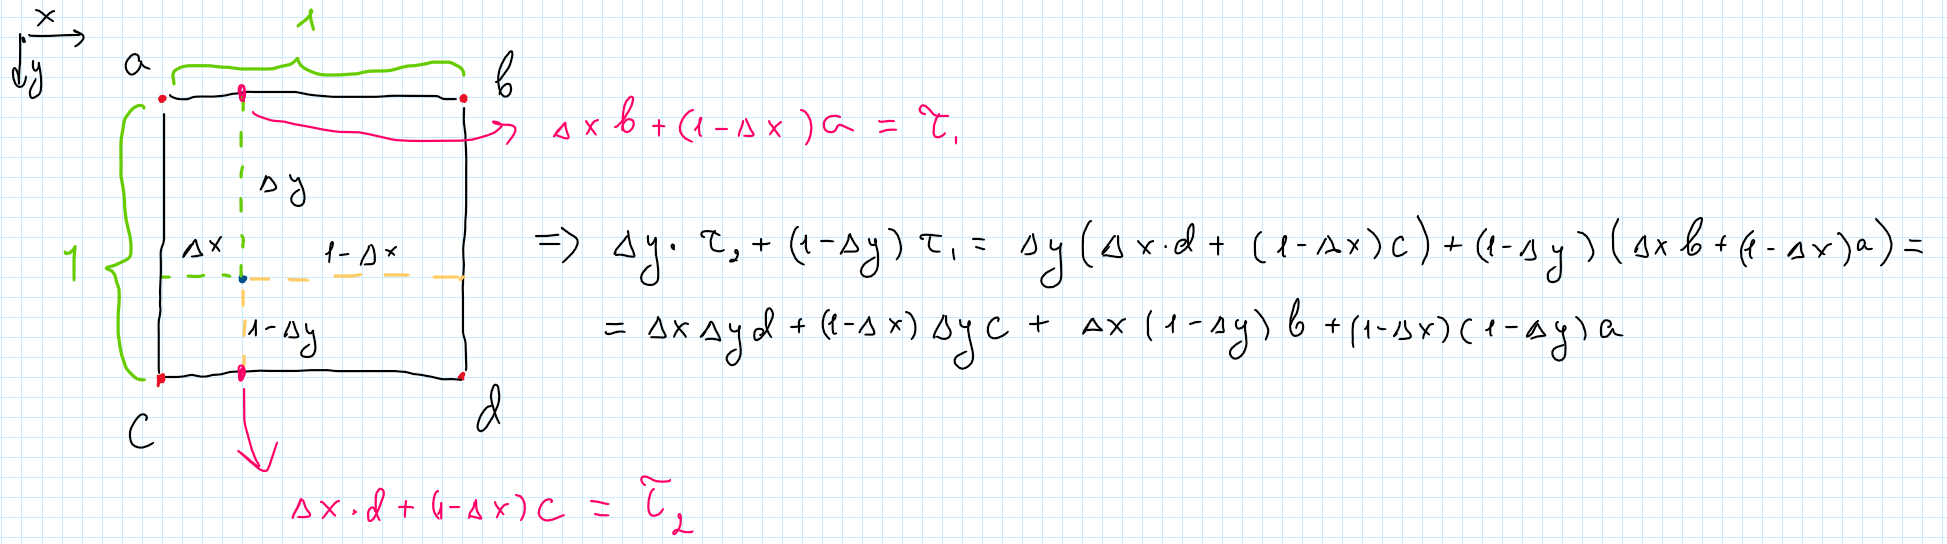

Знаходимо значення точки за формулою([джерело](https://www.youtube.com/watch?v=rLMznzIslVA)):

$$x = (n + 0.5)\cdot \Delta{x} - 0.5$$

В результаті отримаємо точку &tau;<sub>1</sub>, для отримання точки "a" потрібно знайти цілу частину від &tau;<sub>1</sub>, бо занчення пікселів оригінального зображення знаходяться на цілих x.
Аналогічно і для y.

In [45]:
def bilinear_interpolation(img: np.ndarray, resized_shape: tuple) -> np.ndarray:
    Y, X = img.shape[:2]
    # print("Start interpolation...")
    
    dx = X/resized_shape[1]
    dy = Y/resized_shape[0]

    new_img = np.zeros(resized_shape)
    for k in range(resized_shape[2]):
        for y_i in range(resized_shape[0]):
            for x_i in range(resized_shape[1]):
                x = (x_i + .5) * dx - .5
                y = (y_i + .5) * dy - .5

                x_int = min(int(x), X-2)
                y_int = min(int(y), Y-2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = img[y_int, x_int, k]
                b = img[y_int, x_int+1, k]
                c = img[y_int+1, x_int, k]
                d = img[y_int+1, x_int+1, k]

                pixel = a*(1 - x_diff)*(1 - y_diff) + b*x_diff*(1 - y_diff) + c*(1 - x_diff)*y_diff + d*x_diff*y_diff
                new_img[y_i, x_i, k] = pixel
    # print("Interpolation is finished.")
    return new_img.astype("uint8")


Text(0, 0.5, 'Bilinear interpolation')

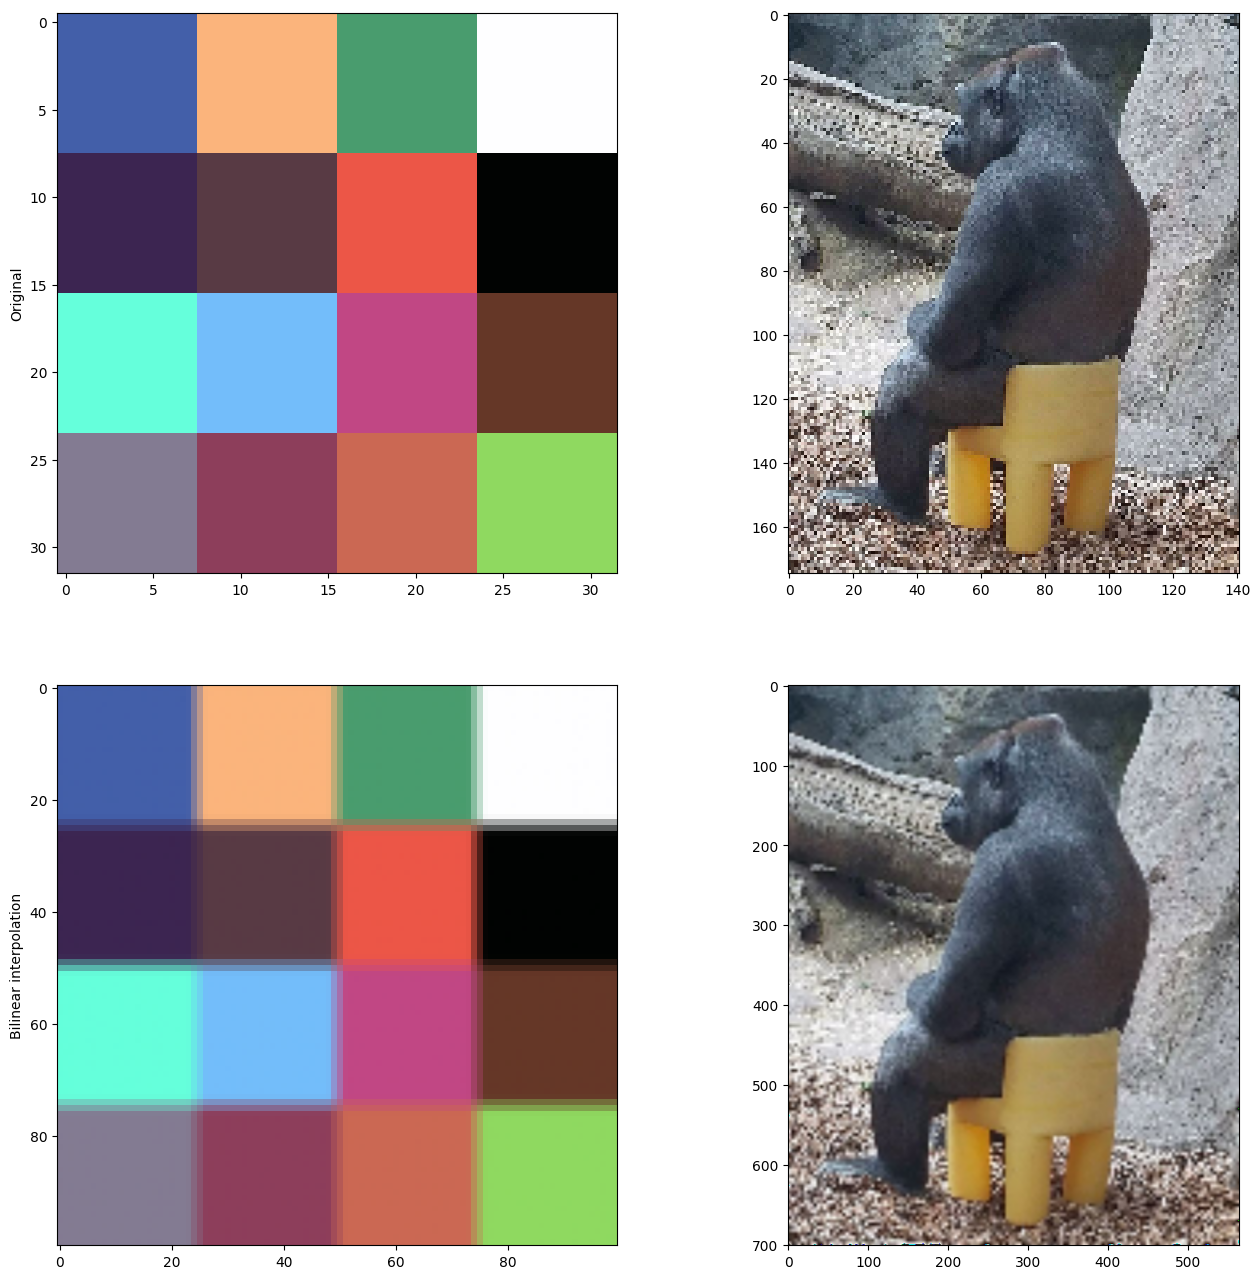

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

ax[0, 0].imshow(cubes)
ax[0, 1].imshow(monkey)
ax[0, 0].set_ylabel("Original")

ax[1, 0].imshow(bilinear_interpolation(cubes, (100, 100, 3)))
ax[1, 1].imshow(bilinear_interpolation(monkey, monkey_shape))
ax[1, 0].set_ylabel("Bilinear interpolation")

<h3 align="center">Бікубічна інтерполяція</h3>

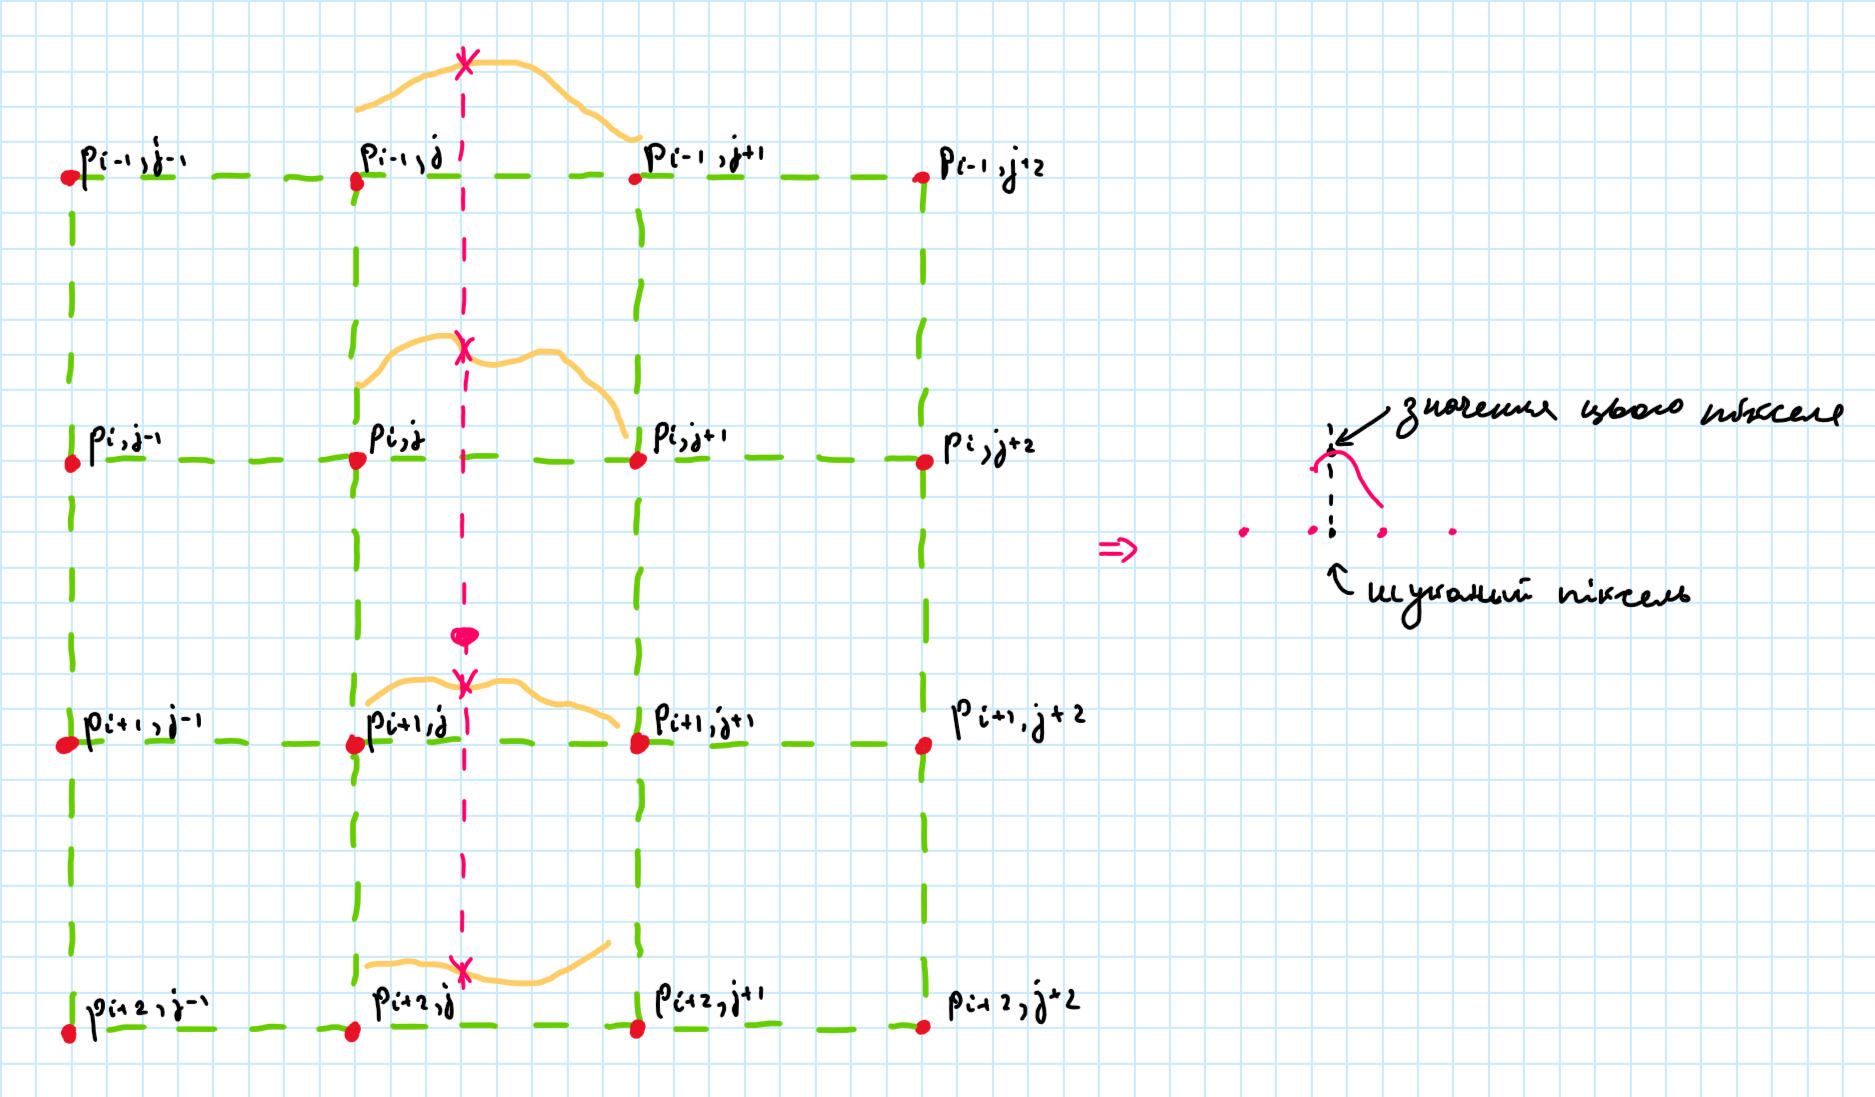

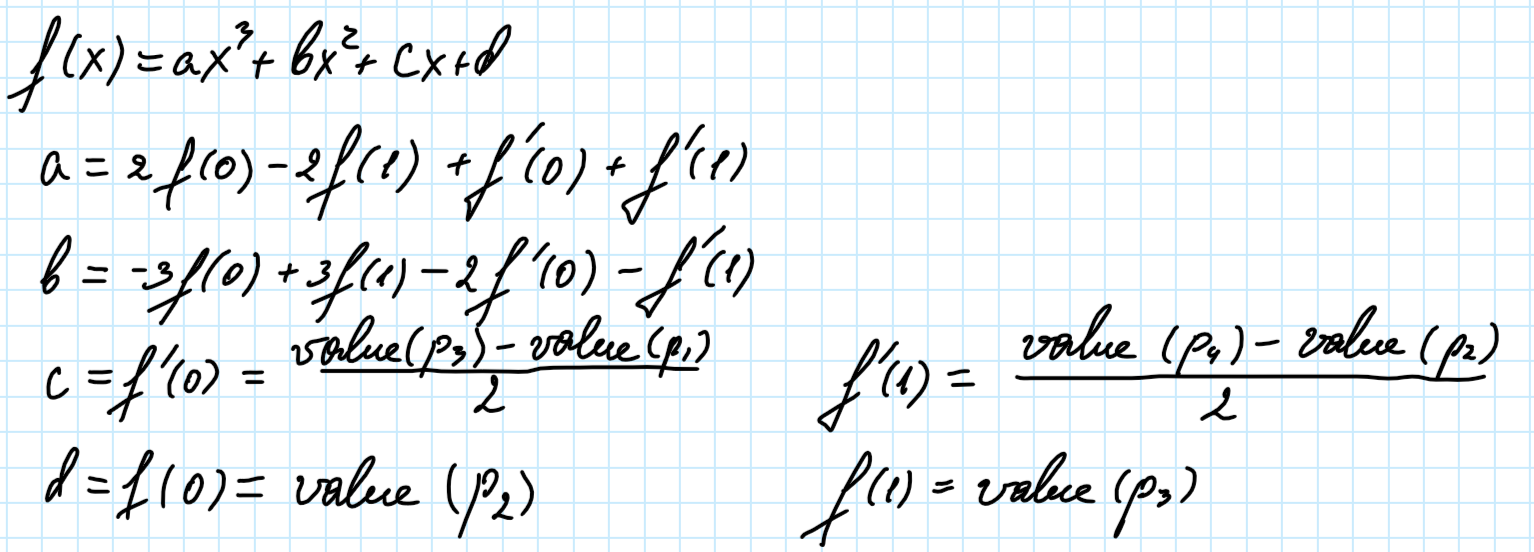

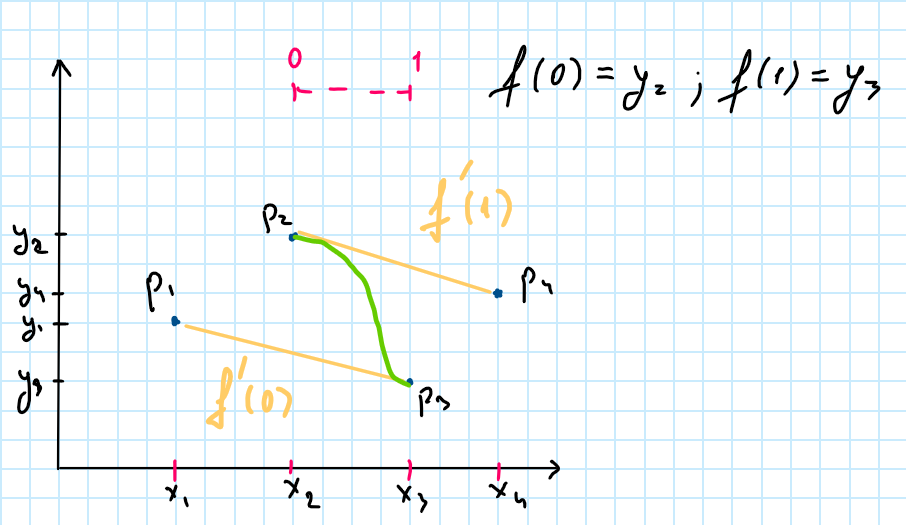

Але можуть бути наступні артефакти


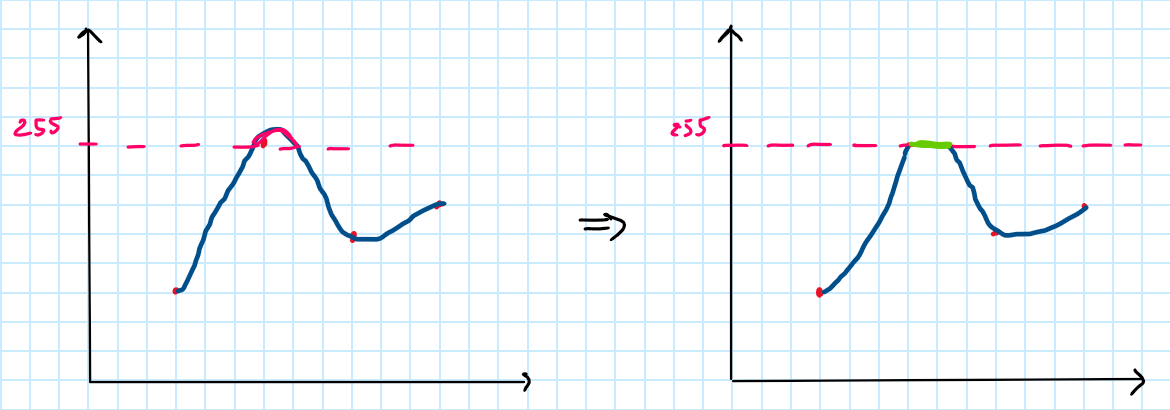


In [3]:
def cubic_f(p: [4], x: float) -> float:
    f_0 = p[1]
    f_1 = p[2]
    df_0 = (p[2] - p[0])/2
    df_1 = (p[3]-p[1])/2
    a = 2*f_0 - 2*f_1 + df_0 + df_1
    b = -3*f_0 + 3*f_1 - 2*df_0 - df_1
    c = df_0
    d = f_0
    return a*(x**3) + b*(x**2) + c*x + d

cubic_f([2, 0, 1.5, 1], .25)

0.17578125

In [51]:
def bicubic_interpolation(img: np.ndarray, resized_shape: tuple) -> np.ndarray:
    # print("Start interpolation...")
    Y, X = img.shape[:2]
    
    dx = X/resized_shape[1]
    dy = Y/resized_shape[0]

    new_img = np.zeros(resized_shape)
    # print(new_img.shape)
    # print(f"\n\nimg:{img.shape}\n\n")
    for k in range(resized_shape[2]):
        for y_i in range(resized_shape[0]):
            for x_i in range(resized_shape[1]):
                # print(f"y_i:{y_i}, x_i:{x_i}")
                x = (x_i + .5) * dx - .5
                y = (y_i + .5) * dy - .5

                x_int = min(int(x), X-2)
                y_int = min(int(y), Y-2)

                P = np.zeros((4, 4))

                # Граничні умови
                if y_int-1 == -1:
                    if x_int-1 == -1:
                        P[0, 0] = img[y_int, x_int, k]
                        P[1:, 0] = img[y_int:y_int+3, x_int, k]
                        P[0, 1:] = img[y_int, x_int:x_int+3, k]
                        P[1:, 1:] = img[y_int:y_int+3, x_int:x_int+3, k]
                        # print("N1")
                    elif x_int+1 >= X-1:
                        P[0, 3] = img[y_int+1, x_int+1, k]
                        P[1:, 3] = img[y_int:y_int+3, x_int+1, k]
                        P[0, :3] = img[y_int, x_int-1:x_int+2, k]
                        P[1:, :3] = img[y_int:y_int+3, x_int-1:x_int+2, k]
                        # print("N2")
                    else:
                        P[0, ...] = img[y_int, x_int-1:x_int+3, k]
                        P[1:, ...] = img[y_int:y_int+3, x_int-1:x_int+3, k]
                        # print("N3")
                elif y_int+1 >= Y-1:
                    if x_int-1 == -1:
                        P[3, 0] = img[y_int+1, x_int, k]
                        P[:3, 0] = img[y_int-1:y_int+2, x_int, k]
                        P[3, 1:] = img[y_int+1, x_int:x_int+3, k]
                        P[1:, :3] = img[y_int-1:y_int+2, x_int:x_int+3, k]
                        # print("N4")
                    elif x_int+1 >= X-1:
                        P[0, 3] = img[y_int+1, x_int+1, k]
                        P[:3, 3] = img[y_int-1:y_int+2, x_int+1, k]
                        P[3, :3] = img[y_int+1, x_int-1:x_int+2, k]
                        # print("N5")
                    else:
                        P[3, ...] = img[y_int+1, x_int-1:x_int+3, k]
                        P[:3, ...] = img[y_int-1:y_int+2, x_int-1:x_int+3, k]
                        # print("N6")
                elif x_int-1 == -1:
                    P[..., 0] = img[y_int-1:y_int+3, x_int, k]
                    P[..., 1:] = img[y_int-1:y_int+3, x_int:x_int+3, k]
                    # print("N7")
                elif x_int+1 >= X-1:
                    P[..., 3] = img[y_int-1:y_int+3, x_int+1, k]
                    P[..., :3] = img[y_int-1:y_int, x_int-1:x_int+2, k]
                    # print("N8")
                else:
                    P = img[y_int-1:y_int+3, x_int-1:x_int+3, k]
                    # print("ELSE")

                # print(P)
                # print("---------------------")
                x_for_f = x - x_int
                y_for_f = y - y_int
                pixel = cubic_f([cubic_f(P[0], x_for_f), cubic_f(P[1], x_for_f), 
                                 cubic_f(P[2], x_for_f), cubic_f(P[3], x_for_f)], y_for_f)
                # print(pixel)
                if pixel < 0:
                    pixel = 0
                elif pixel > 255:
                    pixel = 255
                new_img[y_i, x_i, k] = pixel
    return new_img.astype("uint8")


C:\Users\berku\AppData\Local\Temp\ipykernel_7564\2575725436.py:5: RuntimeWarning: overflow encountered in scalar subtract
  df_1 = (p[3]-p[1])/2
C:\Users\berku\AppData\Local\Temp\ipykernel_7564\2575725436.py:4: RuntimeWarning: overflow encountered in scalar subtract
  df_0 = (p[2] - p[0])/2


Text(0, 0.5, 'Bicubic interpolation')

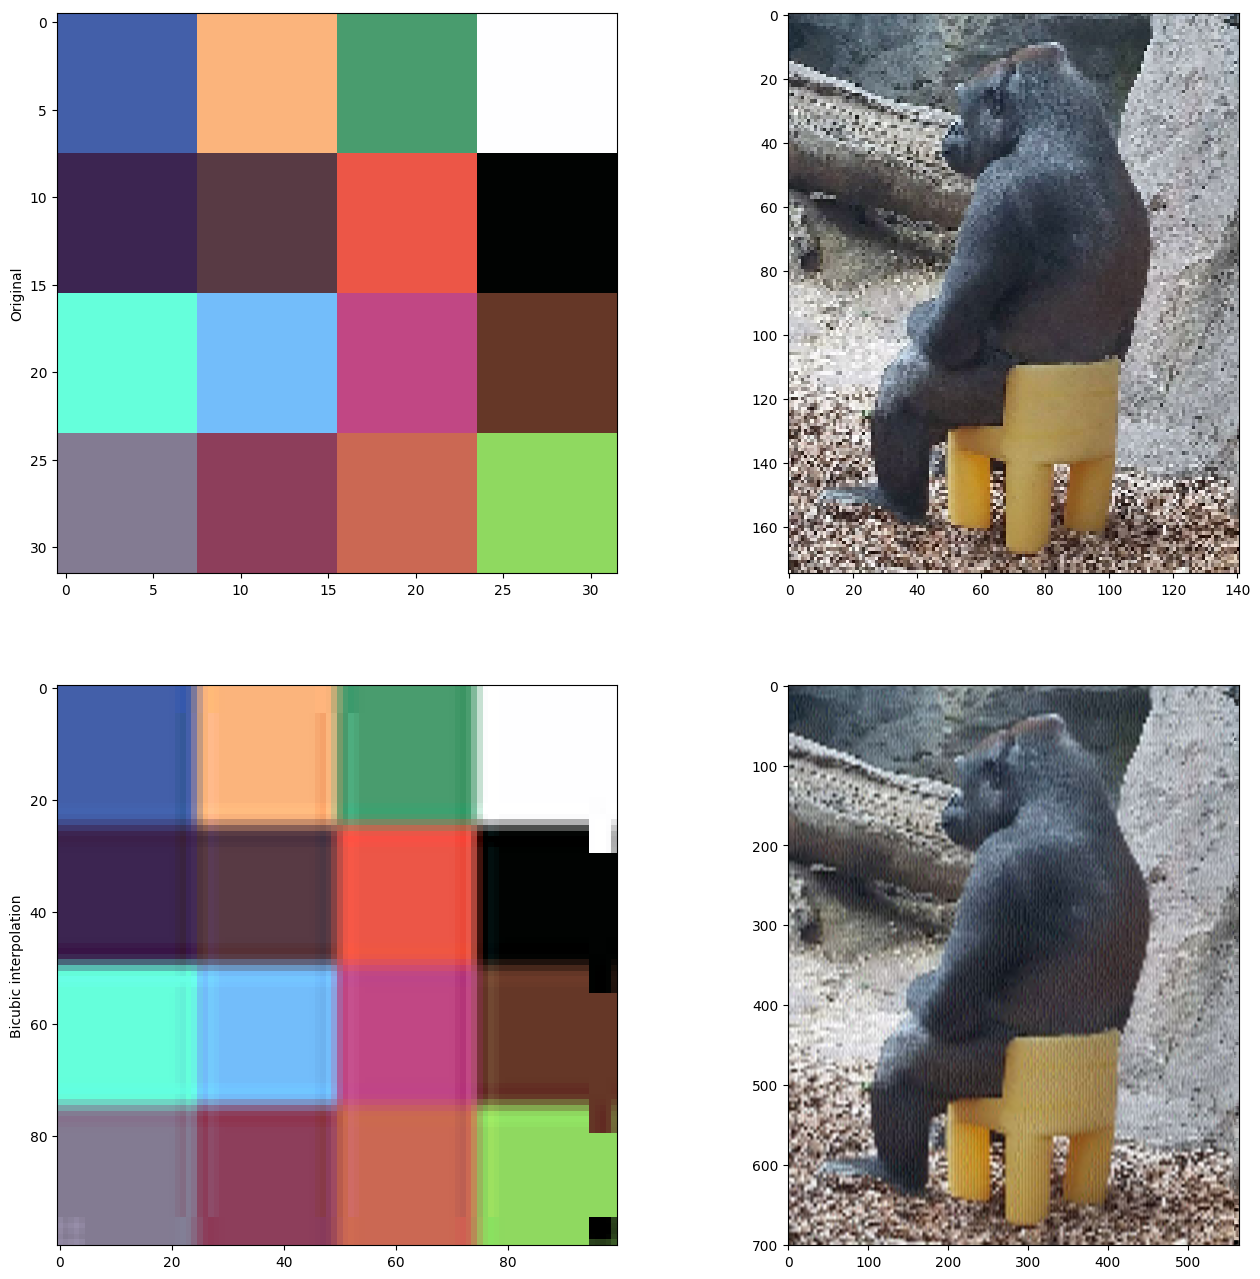

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

ax[0, 0].imshow(cubes)
ax[0, 1].imshow(monkey)
ax[0, 0].set_ylabel("Original")

ax[1, 0].imshow(bicubic_interpolation(cubes, (100, 100, 3)))
ax[1, 1].imshow(bicubic_interpolation(monkey, monkey_shape))
ax[1, 0].set_ylabel("Bicubic interpolation")